# Data exploration train.csv

In [257]:
# Load data
import pandas as pd
train_data = pd.read_csv("data/train.csv")

/home/sabine/miniconda3/envs/minicomp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



In [201]:
# explore data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637774 entries, 0 to 637773
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           637774 non-null  object 
 1   Store          618473 non-null  float64
 2   DayOfWeek      618757 non-null  float64
 3   Sales          618747 non-null  float64
 4   Customers      618683 non-null  float64
 5   Open           618588 non-null  float64
 6   Promo          618580 non-null  float64
 7   StateHoliday   618520 non-null  object 
 8   SchoolHoliday  618437 non-null  float64
dtypes: float64(7), object(2)
memory usage: 43.8+ MB


In [202]:
train_data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,618473.000000,618757.000000,618747.000000,618683.000000,618588.000000,618580.000000,618437.000000
mean,558.105623,3.994914,5668.015834,628.909831,0.829167,0.370447,0.173253
std,321.885545,1.997485,3809.655137,463.786905,0.376363,0.482925,0.378466
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.000000,2.000000,3640.000000,397.000000,1.000000,0.000000,0.000000
50%,558.000000,4.000000,5625.000000,604.000000,1.000000,0.000000,0.000000
75%,837.000000,6.000000,7714.000000,833.000000,1.000000,1.000000,0.000000
max,1115.000000,7.000000,38037.000000,7388.000000,1.000000,1.000000,1.000000


In [203]:
# show example data 
train_data.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0


array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'DayOfWeek'}>,
        <AxesSubplot:title={'center':'Sales'}>],
       [<AxesSubplot:title={'center':'Customers'}>,
        <AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'Promo'}>],
       [<AxesSubplot:title={'center':'SchoolHoliday'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

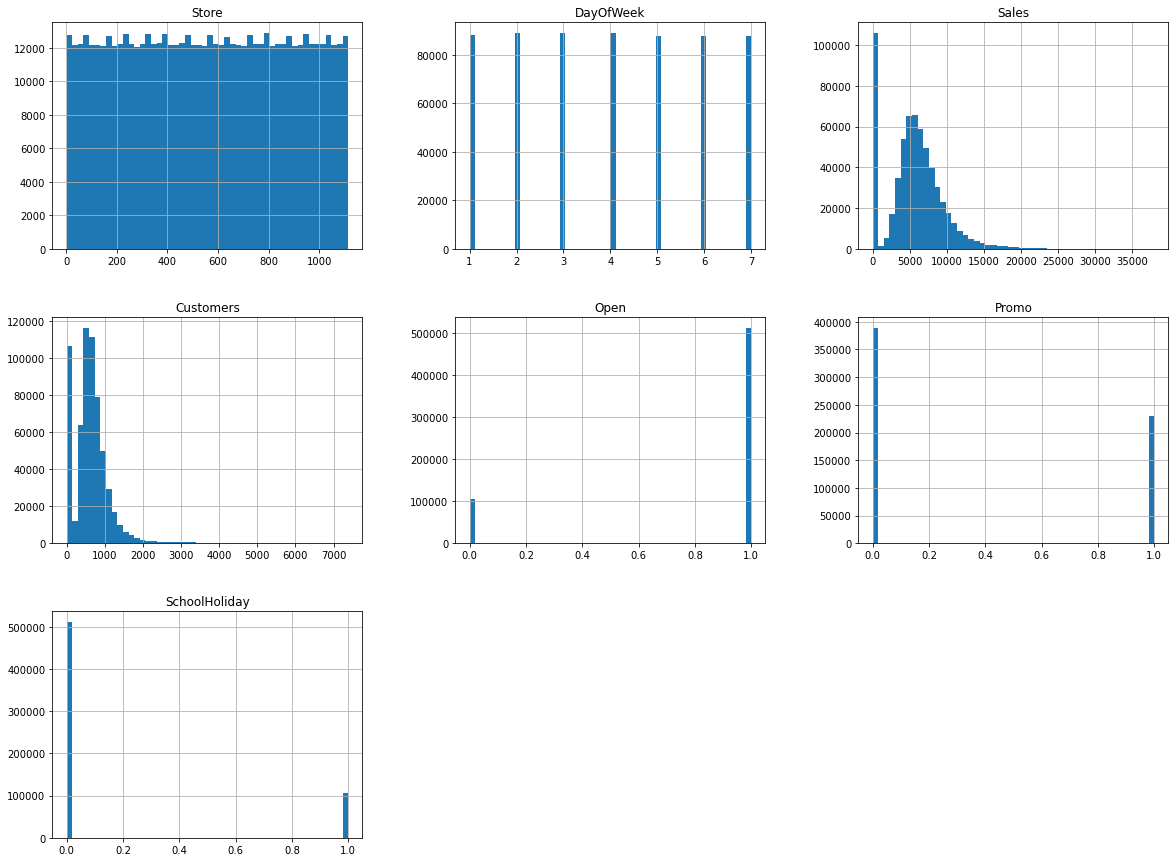

In [204]:
# show histograms
%matplotlib inline 
import matplotlib.pyplot as plt
train_data.hist(bins=50, figsize=(20,15))

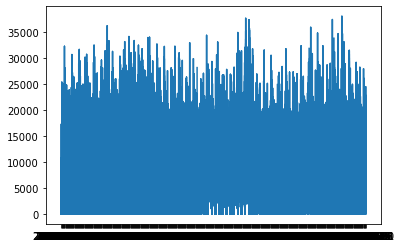

In [205]:
# plot Sales over Date
plt.plot(train_data['Date'], train_data['Sales'])

# Data Preprocessing 1

# Generate validation set

In [258]:
# Split train and validation set at 2014-04-30
validation = train_data[train_data['Date'] > '2014-04-30']
newtrain = train_data[train_data['Date'] <= '2014-04-30']

print(f"New train set length: {len(newtrain)}")
print(f"New validation set length: {len(validation)}")

validation.to_csv("data/validation.csv", header=True)
newtrain.to_csv("data/newtrain.csv", header=True)

New train set length: 540774
New validation set length: 97000


In [207]:
validation.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
540774,2014-05-01,372.0,4.0,0.0,0.0,0.0,1.0,a,0.0
540775,2014-05-01,368.0,4.0,0.0,0.0,0.0,1.0,a,0.0
540776,2014-05-01,369.0,4.0,0.0,0.0,0.0,1.0,a,0.0
540777,2014-05-01,370.0,NaN,NaN,0.0,NaN,1.0,a,0.0
540778,2014-05-01,371.0,4.0,0.0,0.0,0.0,1.0,a,0.0


# Baseline model

In [259]:
# define evaluation metrics
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [260]:
import numpy as np
# get baseline prediction evaluation taking the average of new training set as prediction
print(newtrain.loc[newtrain['Sales'] > 0, 'Sales'].mean())
mean = newtrain.loc[newtrain['Sales'] > 0, 'Sales'].mean()
validation = validation.loc[validation['Sales'] > 0]

preds = np.full(len(validation), mean)
rmspe = metric(preds, np.array(validation['Sales']))

print(f'Prediction: average, RMSPE={rmspe:.2f}%')


6802.905730812207
Prediction: average, RMSPE=55.18%


# Data preprocessing 2

In [261]:
# drop stores with id "nan"

def generate_mapping(data):
    means = data[data['Store'] > 0].groupby(['Store']).mean()['Sales']
    mapping = {}
    # create new store category based on mean sales
    limits = [5000, 7500, 10000]
    new_cat = ["l", "m", "h", "vh"]
    for i, m in enumerate(means):
        mapping[means.index[i]] = new_cat[0]
        for j, l in enumerate(limits):
            if m > l:
                mapping[means.index[i]] = new_cat[j+1]
    return mapping

mapping = generate_mapping(newtrain)


# Data cleaning

In [267]:
# One function to do all the preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

def add_time_features(df):
    print(df.Date)
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['DayOfWeek'] = df.Date.dt.dayofweek
    return df  
    
def map_store_category(data, mapping):
  #  data['Store_cat'] = "l"
    for store, cat in mapping.items():
        data.loc[data['Store'] == store, 'Store_cat'] = cat 
        
store = pd.read_csv('data/store.csv')
    
def preprocess(data, validate=False):
    
    # remove stores with nan id
    # remove rows with Sales=0

    data = data[data['Sales'] > 0]
    data = data[data['Store'] > 0]

    # clean up State holiday 
    data['StateHoliday'] = data['StateHoliday'].replace(0.0, 0)
 #   data['StateHoliday'] = data['StateHoliday'].replace("0", "No")
    data['StateHoliday'] = data['StateHoliday'].replace("a", "Public")
    data['StateHoliday'] = data['StateHoliday'].replace("b", "Easter")
    data['StateHoliday'] = data['StateHoliday'].replace("c", "Christmas")

    
    # create new category store_cat based on mapping
    map_store_category(data, mapping)

    # merge in store.csv
    data = pd.merge(data, store, how='left', on='Store')

    # create/update month and weekday columns
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = add_time_features(data)
    
    # impute most frequent value "0" resp. "No" 

    impute_mode = ['SchoolHoliday', 'StateHoliday', "Promo"]
    cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(impute_mode)),
        ('imputer', SimpleImputer(strategy="constant", fill_value = 0)),
    ])
    data_tr = cat_pipeline.fit_transform(data)

    data.loc[:, impute_mode] = data_tr
    
    # feature categories
    categorical_features = ['StateHoliday', 'SchoolHoliday', 'Store_cat', 'StoreType', 'Assortment', 
                  'DayOfWeek', 'Promo'] #, 'Months']
    numerical_features = ['CompetitionDistance', ]
    target = ['Sales']

    keep_features = categorical_features + numerical_features + target
    
    # use only 'keep_features', do one-hot encoding on categories
    data = data.loc[:, keep_features]
   # print(data.head())
    data.loc[:, categorical_features]  = data.loc[:, categorical_features].astype(str)
    data = pd.get_dummies(data) #, drop_first=True)
    
    
    # Scale target and distance
    num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numerical_features + target)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),

    ])

    if validate:
        data_tr = num_pipeline.transform(data)
    else:
        data_tr = num_pipeline.fit_transform(data)
    data.loc[:, numerical_features + target] = data_tr
    return data

In [268]:
transformed_train = preprocess(newtrain)
transformed_train.to_csv("train_transformed.csv", header)
   # data['StateHoliday'].value_counts() 

0        2013-01-01
1        2013-01-01
2        2013-01-01
3        2013-01-01
4        2013-01-01
            ...    
422586   2014-04-30
422587   2014-04-30
422588   2014-04-30
422589   2014-04-30
422590   2014-04-30
Name: Date, Length: 422591, dtype: datetime64[ns]


In [269]:
transformed_train.info()
transformed_train.describe() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422591 entries, 0 to 422590
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CompetitionDistance     422591 non-null  float64
 1   Sales                   422591 non-null  float64
 2   StateHoliday_0          422591 non-null  uint8  
 3   StateHoliday_Christmas  422591 non-null  uint8  
 4   StateHoliday_Easter     422591 non-null  uint8  
 5   StateHoliday_Public     422591 non-null  uint8  
 6   SchoolHoliday_0.0       422591 non-null  uint8  
 7   SchoolHoliday_1.0       422591 non-null  uint8  
 8   Store_cat_h             422591 non-null  uint8  
 9   Store_cat_l             422591 non-null  uint8  
 10  Store_cat_m             422591 non-null  uint8  
 11  Store_cat_vh            422591 non-null  uint8  
 12  StoreType_a             422591 non-null  uint8  
 13  StoreType_b             422591 non-null  uint8  
 14  StoreType_c         

,CompetitionDistance,Sales,StateHoliday_0,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_Public,SchoolHoliday_0.0,SchoolHoliday_1.0,Store_cat_h,Store_cat_l,...,Assortment_c,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Promo_0.0,Promo_1.0
count,4.225910e+05,4.225910e+05,422591.000000,422591.000000,422591.000000,422591.000000,422591.000000,422591.000000,422591.000000,422591.000000,...,422591.000000,422591.000000,422591.000000,422591.000000,422591.000000,422591.000000,422591.000000,422591.000000,422591.000000,422591.000000
mean,9.802695e-17,9.333743e-17,0.999115,0.000083,0.000215,0.000587,0.817573,0.182427,0.098999,0.422555,...,0.459818,0.162751,0.171135,0.165638,0.161035,0.164705,0.170756,0.003980,0.582757,0.417243
std,1.000001e+00,1.000001e+00,0.029736,0.009100,0.014673,0.024218,0.386196,0.386196,0.298661,0.493966,...,0.498383,0.369139,0.376627,0.371756,0.367564,0.370915,0.376296,0.062963,0.493104,0.493104
min,-6.984732e-01,-2.161883e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.080129e-01,-6.741608e-01,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-4.012465e-01,-1.928389e-01,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.880378e-01,4.453582e-01,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.102255e+00,9.996923e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [270]:
validation_transformed = preprocess(validation)
for c in transformed_train.columns:
    if not c in validation_transformed.columns:
        validation_transformed[c] = 0
#print(validation_transformed)
validation_transformed.info()
validation_transformed.describe()

0       2014-05-01
1       2014-05-01
2       2014-05-01
3       2014-05-01
4       2014-05-01
           ...    
74780   2014-07-31
74781   2014-07-31
74782   2014-07-31
74783   2014-07-31
74784   2014-07-31
Name: Date, Length: 74785, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74785 entries, 0 to 74784
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CompetitionDistance     74785 non-null  float64
 1   Sales                   74785 non-null  float64
 2   StateHoliday_0          74785 non-null  uint8  
 3   StateHoliday_Public     74785 non-null  uint8  
 4   SchoolHoliday_0.0       74785 non-null  uint8  
 5   SchoolHoliday_1.0       74785 non-null  uint8  
 6   Store_cat_h             74785 non-null  uint8  
 7   Store_cat_l             74785 non-null  uint8  
 8   Store_cat_m             74785 non-null  uint8  
 9   Store_cat_vh            74785 non-null  uint8

,CompetitionDistance,Sales,StateHoliday_0,StateHoliday_Public,SchoolHoliday_0.0,SchoolHoliday_1.0,Store_cat_h,Store_cat_l,Store_cat_m,Store_cat_vh,...,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Promo_0.0,Promo_1.0,StateHoliday_Christmas,StateHoliday_Easter
count,7.478500e+04,7.478500e+04,74785.000000,74785.000000,74785.000000,74785.000000,74785.000000,74785.000000,74785.000000,74785.000000,...,74785.000000,74785.000000,74785.000000,74785.000000,74785.000000,74785.000000,74785.000000,74785.000000,74785.0,74785.0
mean,1.792628e-16,-8.091111e-17,0.997954,0.002046,0.824978,0.175022,0.100461,0.417717,0.447857,0.033964,...,0.170943,0.170475,0.148613,0.172976,0.172815,0.005095,0.562145,0.437855,0.0,0.0
std,1.000007e+00,1.000007e+00,0.045185,0.045185,0.379988,0.379988,0.300616,0.493186,0.497277,0.181138,...,0.376462,0.376052,0.355709,0.378229,0.378090,0.071195,0.496126,0.496126,0.0,0.0
min,-6.923171e-01,-2.083581e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,-6.049008e-01,-6.728942e-01,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,-3.996625e-01,-1.830000e-01,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0
75%,1.767784e-01,4.561766e-01,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0
max,8.915876e+00,1.010641e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0


In [271]:
X_train = transformed_train.drop(columns = ['Sales'])
y_train = transformed_train['Sales']
X_valid = validation_transformed.drop(columns = ['Sales'])
y_valid = validation_transformed['Sales']

# Stationary model

In [251]:
# Check stationarity

from statsmodels.tsa.stattools import adfuller
pvalues = []
store_ids = newtrain_set['Store'].unique()
for id in store_ids:
    result = adfuller(newtrain_set.loc[newtrain_set['Store'] == id, 'Sales'])
 #   print('ADF Statistic: %f' % result[0])
    pvalues.append(result[1])

df_pvalues = pd.DataFrame({
        "Store" : store_ids,
        "pvalue" : pvalues,
})

# Plotly Express is now a sublibrary of Plotly:
import plotly.express as px
fig = px.scatter(
    data_frame=df_pvalues,
    x='Store',
    y='pvalue',
    title='P values per store',
    log_y = True
)
fig.add_hline(y=0.05)
fig.show()




KeyboardInterrupt: 

In [272]:
# Linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


LinearRegression()

In [274]:
print(X_train.shape)
print(X_valid.shape)
y_pred = lin_reg.predict(X_valid)
rmspe = metric(y_pred, np.array(y_valid))
print(y_pred.mean())
print(y_valid.mean())
print(y_train.mean())

print(f'Prediction: average, RMSPE={rmspe:.2f}%')

(422591, 27)
(74785, 27)
-82727878519.4297
-8.091111223924622e-17
9.333743390103602e-17
Prediction: average, RMSPE=5158302949817529.00%


In [ ]:
fig = px.histogram(
    data_frame=newtrain,
    x='CompetitionDistance',
    title='Competition Distance',
   # log_x = True
)
fig.show()